In [1]:
import timeit
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np

In [3]:
from graphax.sparse.block import BlockSparseTensor, SparseDimension
import jax.random as jrand
block_nums = 16
block_size = 16
k1, k2 = jrand.split(jrand.PRNGKey(42), 2)
x=BlockSparseTensor([SparseDimension(0,block_nums,0,1)],[SparseDimension(1,block_nums,0,0)], jrand.normal(k1, (block_nums,block_size,block_size)))
y=BlockSparseTensor([SparseDimension(0,block_nums,0,1)],[SparseDimension(1,block_nums,0,0)], jrand.normal(k2, (block_nums,block_size,block_size)))

In [6]:
%timeit x@y

9.86 ms ± 4.23 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
%timeit x2@y2

362 μs ± 77.6 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [8]:
res: dict[int, dict[int, dict[str, list[float]]]] = {}
# loop size of overall array
for block_nums in [1,2,4,6,8,10,20,40,60,80,100,200,400,800,1000,2000,4000,6000,8000,10000]:
    print("number of blocks:", block_nums)
    res[block_nums] = {}
    # loop size of individual blocks
    for block_size in tqdm([1, 2, 4, 6, 8, 10, 20, 40, 60, 80, 100]):
        res[block_nums][block_size] = {}
        
        res[block_nums][block_size]['dense'] = timeit.repeat("x@y", 
                      "from graphax.sparse.block import BlockSparseTensor, SparseDimension;"
                      "import jax.random as jrand;"
                      "k1, k2 = jrand.split(jrand.PRNGKey(42), 2);"
                      f"x=BlockSparseTensor([SparseDimension(0,{block_nums},0,1)],[SparseDimension(1,{block_nums},0,0)], jrand.normal(k1, ({block_nums},{block_size},{block_size}))).dense();"
                      f"y=BlockSparseTensor([SparseDimension(0,{block_nums},0,1)],[SparseDimension(1,{block_nums},0,0)], jrand.normal(k2, ({block_nums},{block_size},{block_size}))).dense();", 
                      repeat=10, number=1)
        
        n = block_nums*block_size
        res[block_nums][block_size]['dense_mul_sum'] = [n**3, (n-1)*n**2]
        
        res[block_nums][block_size]['square_sparse'] = timeit.repeat("x@y", 
                      "from graphax.sparse.block import BlockSparseTensor, SparseDimension;"
                      "import jax.random as jrand;"
                      "k1, k2 = jrand.split(jrand.PRNGKey(42), 2);"
                      f"x=BlockSparseTensor([SparseDimension(0,{block_nums},0,1)],[SparseDimension(1,{block_nums},0,0)], jrand.normal(k1, ({block_nums},{block_size},{block_size})));"
                      f"y=BlockSparseTensor([SparseDimension(0,{block_nums},0,1)],[SparseDimension(1,{block_nums},0,0)], jrand.normal(k2, ({block_nums},{block_size},{block_size})));", 
                      repeat=10, number=1)
        
        res[block_nums][block_size]['square_sparse_mul_sum'] = [block_size**3*block_nums, (block_size-1)*block_size**2*block_nums]
        

number of blocks: 1


100%|██████████| 11/11 [00:04<00:00,  2.64it/s]


number of blocks: 2


100%|██████████| 11/11 [00:03<00:00,  3.30it/s]


number of blocks: 4


100%|██████████| 11/11 [00:04<00:00,  2.48it/s]


number of blocks: 6


100%|██████████| 11/11 [00:07<00:00,  1.52it/s]


number of blocks: 8


100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


number of blocks: 10


100%|██████████| 11/11 [00:09<00:00,  1.21it/s]


number of blocks: 20


100%|██████████| 11/11 [00:22<00:00,  2.03s/it]


number of blocks: 40


100%|██████████| 11/11 [01:09<00:00,  6.34s/it]


number of blocks: 60


100%|██████████| 11/11 [01:38<00:00,  8.94s/it]


number of blocks: 80


100%|██████████| 11/11 [03:57<00:00, 21.57s/it]


number of blocks: 100


 27%|██▋       | 3/11 [00:08<00:22,  2.77s/it]


KeyboardInterrupt: 

In [131]:
import json
with open("naive_square_sparse.json", "w") as f:
    json.dump(res, f, sort_keys=True, indent=4)

In [39]:
res.keys()

dict_keys(['1', '2', '4', '6', '8', '10', '20', '40', '60', '80', '100', '200'])

In [41]:
import json
with open("naive_square_sparse.json", "r") as f:
    res = json.load(f)

for key, val in list(res.items()):
    res[int(key)] = val
    del res[key]
    
    for key2, val2 in list(val.items()):
        res[int(key)][int(key2)] = val2
        del res[int(key)][key2]

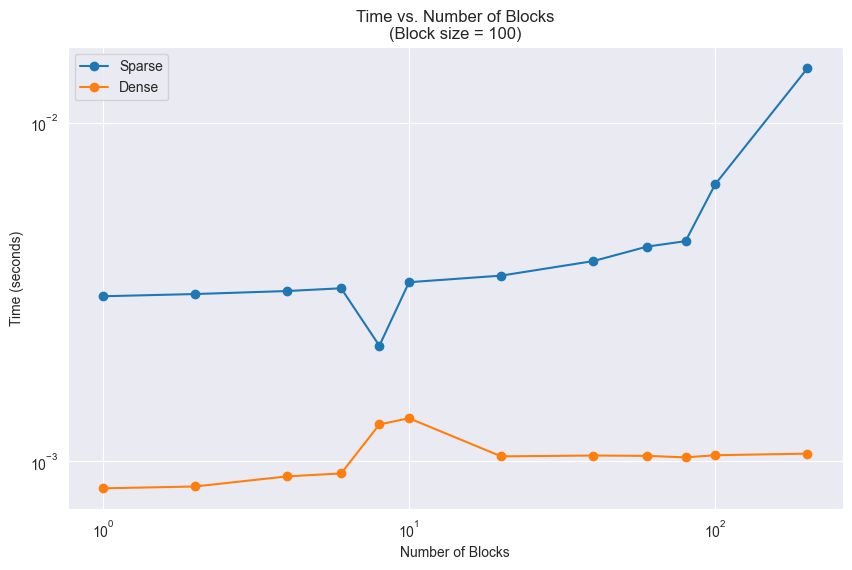

In [42]:
block_size_to_plot = 100
blocks_list = []
sparse_time_list = []
dense_time_list = []

for blocks, block_sizes in res.items():
    if block_size_to_plot in block_sizes:
        blocks_list.append(blocks)
        sparse_time_list.append(np.mean(block_sizes[block_size_to_plot]['naive_square_sparse']))
        dense_time_list.append(np.mean(block_sizes[block_size_to_plot]['dense']))
        

plt.figure(figsize=(10, 6))
plt.plot(blocks_list, sparse_time_list, marker='o', label=f"Sparse")
plt.plot(blocks_list, dense_time_list, marker='o', label=f"Dense")
plt.xlabel("Number of Blocks")
plt.ylabel("Time (seconds)")
plt.title(f"Time vs. Number of Blocks\n(Block size = {block_size_to_plot})")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

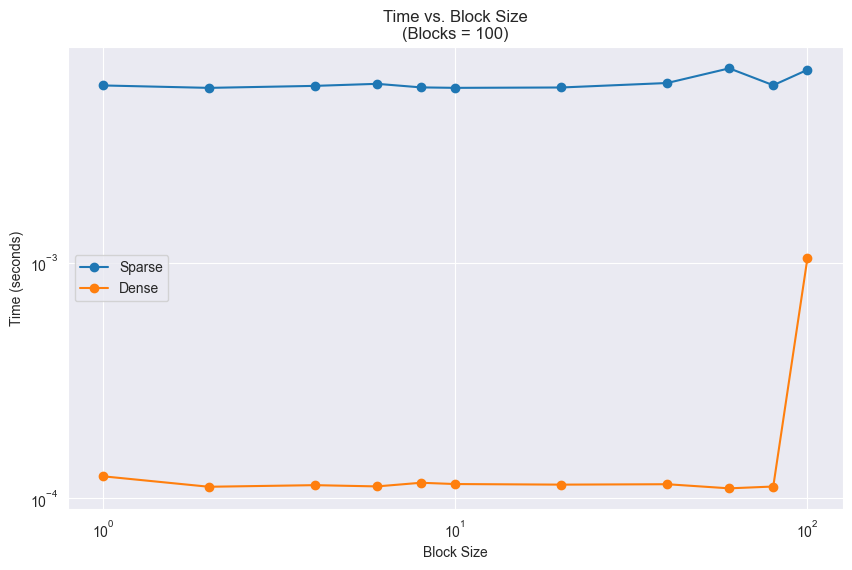

In [43]:
blocks_to_plot = 100
block_sizes_list = []
sparse_time_list = []
dense_time_list = []

if blocks_to_plot in res:
    r = res[blocks_to_plot]
    for block_size in r:
        block_sizes_list.append(block_size)
        sparse_time_list.append(np.mean(r[block_size]['naive_square_sparse']))
        dense_time_list.append(np.mean(r[block_size]['dense']))

plt.figure(figsize=(10, 6))
plt.plot(block_sizes_list, sparse_time_list, marker='o', label=f"Sparse")
plt.plot(block_sizes_list, dense_time_list, marker='o', label=f"Dense")
plt.xlabel("Block Size")
plt.ylabel("Time (seconds)")
plt.title(f"Time vs. Block Size\n(Blocks = {blocks_to_plot})")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

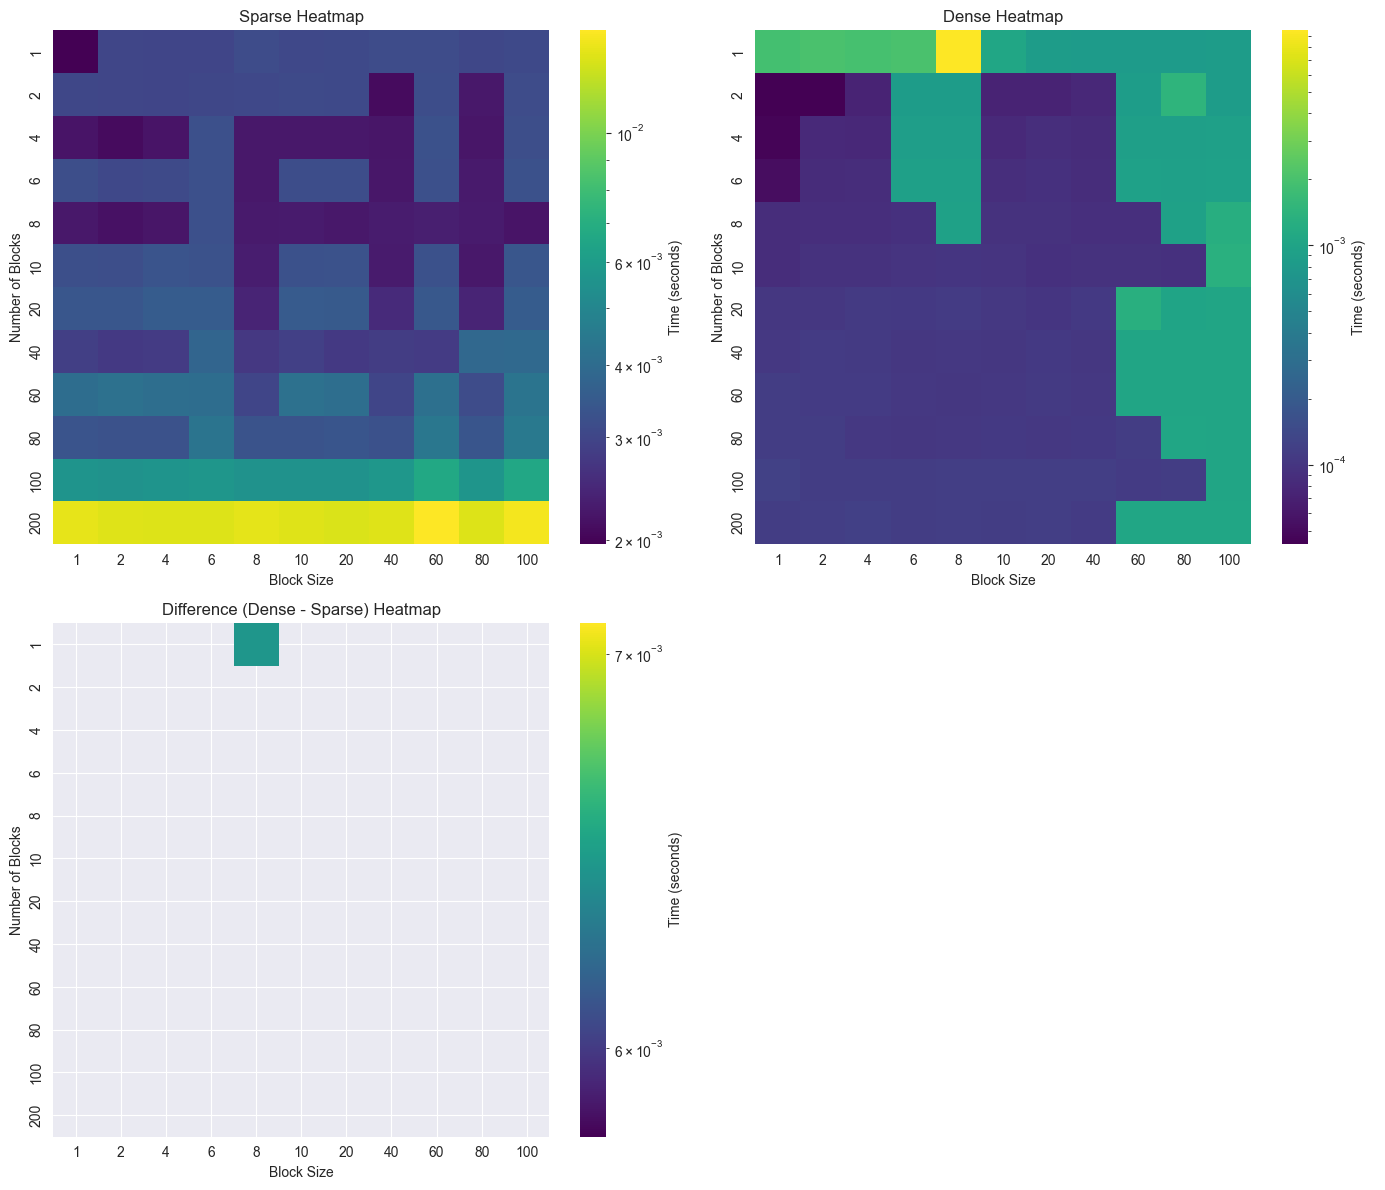

In [50]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sparse_heatmap_data = []
dense_heatmap_data = []
blocks_labels = sorted(res.keys())
block_sizes_labels = sorted(next(iter(res.values())).keys())

for blocks in blocks_labels:
    sparse_row = []
    dense_row = []
    for block_size in block_sizes_labels:
        sparse_row.append(np.mean(res[blocks][block_size]['naive_square_sparse']))
        dense_row.append(np.mean(res[blocks][block_size]['dense']))
    sparse_heatmap_data.append(sparse_row)
    dense_heatmap_data.append(dense_row)

sparse_heatmap_data = np.array(sparse_heatmap_data)
dense_heatmap_data = np.array(dense_heatmap_data)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

sns.heatmap(
    sparse_heatmap_data,
    ax=axes[0, 0],
    xticklabels=block_sizes_labels,
    yticklabels=blocks_labels,
    norm=plt.matplotlib.colors.LogNorm(),
    cmap="viridis",
    cbar_kws={"label": "Time (seconds)"}
)
axes[0, 0].set_xlabel("Block Size")
axes[0, 0].set_ylabel("Number of Blocks")
axes[0, 0].set_title("Sparse Heatmap")

sns.heatmap(
    dense_heatmap_data,
    ax=axes[0, 1],
    xticklabels=block_sizes_labels,
    yticklabels=blocks_labels,
    norm=plt.matplotlib.colors.LogNorm(),
    cmap="viridis",
    cbar_kws={"label": "Time (seconds)"}
)
axes[0, 1].set_xlabel("Block Size")
axes[0, 1].set_ylabel("Number of Blocks")
axes[0, 1].set_title("Dense Heatmap")

sns.heatmap(
    dense_heatmap_data - sparse_heatmap_data,
    ax=axes[1, 0],
    xticklabels=block_sizes_labels,
    yticklabels=blocks_labels,
    norm=plt.matplotlib.colors.LogNorm(),
    cmap="viridis",
    cbar_kws={"label": "Time (seconds)"}
)
axes[1, 0].set_xlabel("Block Size")
axes[1, 0].set_ylabel("Number of Blocks")
axes[1, 0].set_title("Difference (Dense - Sparse) Heatmap")

axes[1, 1].axis('off')
plt.tight_layout()

plt.show()